In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
import json
# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    Model
)
from gammapy.estimators import ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit
import import_parameters_helper

In [2]:
def single_plot_significance(analysis):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    analysis.significance()
    analysis.success ()
    for i ,ax in enumerate(analysis.amplitudes_x):
        if i == 0:
            labels_ = labels
        else:
            labels_ = ['']*4
        ax1.plot(ax, analysis.TS_standard[i], fmt_standard, color= color_overall_standard, label = labels_[0],
                markersize = 8)
        ax1.plot(ax, analysis.TS_N_under[i], fmts[0], color= colors_case[0], markersize = 8,
                    label = labels_[1])
        ax1.plot(ax, analysis.TS_N[i], fmts[1], color= colors_case[1], markersize = 16,
                    label = labels_[1])
        ax1.plot(ax, analysis.TS_N_over[i], fmts[2], color= colors_case[2], markersize = 8,
                    label = labels_[1])
        
    ax1.set_yscale('log'); 
    ax1.legend()
    ax1.set_ylabel("Significance [$\sigma$]")
    ax1.set_title(analysis.title)

    res =  np.array(analysis.TS_standard) - np.array(analysis.TS_N)
    ax2.plot(analysis.amplitudes_x, res, 'o', color= 'black')
    ax2.set_ylabel("$\sigma_{Standard} - \sigma_{Nuisance}$")
    ax2.set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
    #ax2.hlines(0, xlim_all[0], xlim_all[1], color = 'grey')
    #ax2.grid();  ax1.grid();

    return plt.gcf(), ax1, ax2

def single_plot_amplitudes(analysis):
    analysis.best_fit_amplitudes()
    fig, ax = plt.subplots(1,1, )#figsize =(10,10))
    ax = [ax]
    color = 'red'
    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.3,analysis.ampli_standard,
                   yerr = np.array(analysis.err_standard), fmt =fmt_standard, color= color_overall_standard,  
                   markersize = 8,
                  label =labelstandard)
    ax[0].errorbar(analysis.amplitudes_x, analysis.ampli_N_under,
                   yerr = np.array(analysis.err_N_under) , fmt = fmts[0], 
                   color= colors_case[0], markersize = 8,
                  label = labels[0])
    ax[0].errorbar(analysis.amplitudes_x, analysis.ampli_N,
                   yerr = np.array(analysis.err_N) , fmt = fmts[1], 
                   color= colors_case[1], markersize = 16,
                  label = labels[1])
    ax[0].errorbar(analysis.amplitudes_x, analysis.ampli_N_over,
                   yerr = np.array(analysis.err_N_over) , fmt = fmts[2], 
                   color= colors_case[2], markersize = 8,
                  label = labels[2])
    xlim = ax[0].set_xlim(); 

    ax[0].set_ylim(ylim_ampli); 
    #xlim = ax[0].set_xlim(xlim_all[0], xlim_all[1]); 
    ax[0].set_xlabel("Random Draw Number")
    ax[0].set_ylabel("Best Fit Amplitude \n [Input Amplitude]")
    ax[0].hlines(1, analysis.amplitudes_x[0], analysis.amplitudes_x[-1], color = "grey")
    ax[0].legend(title= f"N = {len(analysis.rnds)}")
    ax[0].set_title(analysis.title)

def single_plot_norm(analysis ):
    analysis.best_fit_norm()
    fig, ax = plt.subplots(1,1, )#figsize =(10,10))
    ax = [ax]
    color = 'red'
    print("analysis.norm_err_standard", analysis.norm_err_standard)
    print("analysis.norm_x_mins_N", analysis.norm_err_N)

    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.3,analysis.norm_standard,
                   yerr = np.array(analysis.norm_err_standard), fmt =fmt_standard, 
                   color= color_overall_standard, 
                   markersize = 8, label = labelstandard)
    ax[0].errorbar(analysis.amplitudes_x, analysis.norm_N_under,
                   yerr = np.array(analysis.norm_err_N_under) , fmt = fmts[0], color= colors_case[0], 
                   markersize = 8,
                  label = labels[0])
    ax[0].errorbar(analysis.amplitudes_x, analysis.norm_N,
                   yerr = np.array(analysis.norm_err_N) , fmt = fmts[1], color= colors_case[1], 
                   markersize = 16,
                  label = labels[1])
    ax[0].errorbar(analysis.amplitudes_x, analysis.norm_N_over,
                   yerr = np.array(analysis.norm_err_N_over) , fmt = fmts[2], color= colors_case[2], 
                   markersize = 8,
                  label = labels[2])
    xlim = ax[0].set_xlim(); 
    ax[0].set_ylim(ylim_norm) ; 
    x_ = ax[0].get_xlim()
    xlim = ax[0].set_xlim(x_[0], x_[1]); 

    ax[0].set_xlabel("Random Draw Number")
    ax[0].set_ylabel("Best Fit Norm \n [Input Norm]")
    ax[0].hlines(1, analysis.amplitudes_x[0], analysis.amplitudes_x[-1], color = "grey")
    ax[0].legend(title= f"N = {len(analysis.rnds)}", ncol =2 )

    ax[0].set_title(analysis.title)


def single_plot_parameter_overview(analysis):
    fig = plt.figure()
    par_names = ['norm', 'amplitude', 'index', 'lon_0', 'lat_0']
    par_input = dict()
    par_input['norm'] = 1
    par_input['tilt'] = 1
    par_input['amplitude'] = analysis.amplitude
    par_input['index'] = 2.4
    par_input['lon_0'] = 83.6
    par_input['lat_0'] = 22.0

    for i, par_name in enumerate(par_names):
        tupel = analysis.get_parameters(par_name)
        if par_name == 'tilt':
            tupel = np.array(tupel) +1 
        tupel = np.array(tupel) / par_input[par_name]
        (mean_par_standard, mean_par_err_standard, mean_par_N_under, mean_par_err_N_under, mean_par_N, mean_par_err_N, mean_par_N_over,mean_par_err_N_over) = tupel
        if i == 0:
            labels_ = [labelstandard]+ labels
        else:
            labels_ = ['', ''] * 2
        plt.errorbar(y = i-0.1, x =mean_par_standard, xerr =  mean_par_err_standard,fmt = fmt_standard, 
                     color= color_overall_standard , label = labels_[0])
        plt.errorbar(y = i, x =mean_par_N_under, xerr =  mean_par_err_N_under, fmt = fmts[0], 
                     color = colors_case[0], label = labels_[1])
        plt.errorbar(y = i+0.1, x =mean_par_N, xerr =  mean_par_err_N, fmt = fmts[1], 
                     color = colors_case[1], label = labels_[2])
        plt.errorbar(y = i+0.2, x =mean_par_N_over, xerr =  mean_par_err_N_over, fmt = fmts[2], 
                     color = colors_case[2], label = labels_[3])

    plt.xlabel('Best Fit Par. Value [Input Par. Value]')
    plt.yticks(np.linspace(0, len(par_names)-1, len(par_names) ),
              par_names)
    plt.legend(title= f"N = {len(analysis.rnds)}" )
    
    ylim  = plt.ylim()
    plt.vlines(1, ylim[0], ylim[1], color = 'grey')
    plt.title('Best Fit Model Parameters')


In [3]:
source = "Crab"
added = '_008'
ebins = range(6,20)
outputfolder = 'output/data_asimov_tests'



plotaa= '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters/Asimov/plots'

In [4]:
ylim_sig = (0.2, 5e4)
ylim_ampli = (0.5, 1.5)
ylim_norm= (0.98, 1.02)
ylim_L_scan = (-0.3,2)
#xlim_all = (0.005623413251903491, 1778.2794100389228)
xlim_all = (0.005623413251903491, 100)
colors_case = ['darkorange', 'red', 'maroon', 'grey', 'grey']
fmt_standard = 'o'
fmts = [ 'x',  'x', 'x']
color_overall_standard = 'green'
label = 'Correct Est. ($\mu$ +  $\sigma$)'
labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
labelstandard = "No Nuisance Par. "
labels = [labelunder,label, labelover
         ]

with open('1-amplitudes_where_sys_smaller.json', 'r') as fp:
    a_threshold  = json.load(fp)
print(a_threshold)

{'pointsource_center': '1e-12', 'gaussiansource_center': '1e-12', 'largegaussiansource_center': '1e-10'}


## Load Single Amplitudes

### 1e-12

In [5]:
def get_finished_rnds(amplitude):
    outputfile = '/OOutput'+str(amplitude)+'.json'

    with open(outputfolder+outputfile, 'r') as f:
        data = json.load(f)
    rnds = list(data.keys()) 
    rnd_started, rnd_finished = [], []
    for i in range(len(rnds)):
        try:
            data[str(rnds[i])]['result']['success_N_under'] 
            rnd_finished.append(int(rnds[i]))
        except:
            None
    return rnd_finished

[0, 1, 2, 3, 4, 5, 6, 20, 21, 22, 23, 24, 25, 26, 27, 28, 40, 41, 42, 43, 44, 45, 46, 47, 48, 60, 61, 62, 63, 64, 65, 66, 67, 68, 80, 81, 82, 83, 84, 85, 86, 87]
analysis.norm_err_standard [0.001955816947121057, 0.00195464379304447, 0.001955241731930227, 0.0019561880566328488, 0.001958985451335243, 0.0019561437599247156, 0.0019548647384503236, 0.001954484969250214, 0.0019584952008799, 0.001955270738666778, 0.0019560687838349705, 0.001956709209456852, 0.001958559084580801, 0.0019556561015155764, 0.0019563058711111513, 0.0019560603960866872, 0.0019575851240297188, 0.00195330316546045, 0.0019584423613680383, 0.0019558342444669246, 0.0019566116684349285, 0.001956262319959939, 0.001955636170559827, 0.001954025175031126, 0.0019582166032288814, 0.0019570866993718528, 0.0019569114136542454, 0.001958243617069086, 0.0019570198979486702, 0.001955402059333302, 0.0019568088874964366, 0.0019560498825616297, 0.001957025450707341, 0.0019578835582491805, 0.001957645986956845, 0.0019558198984145217, 0.0

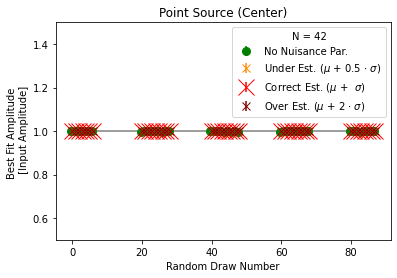

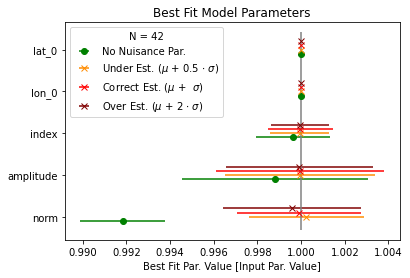

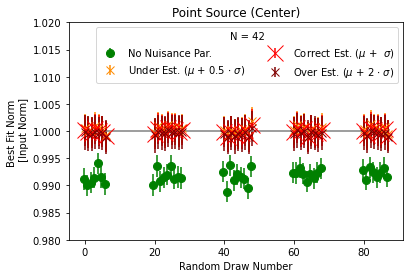

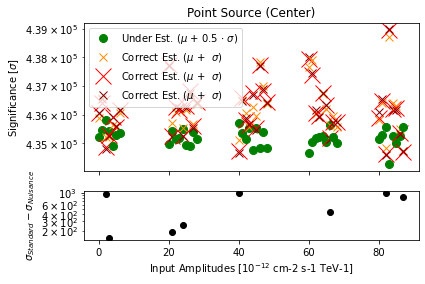

In [6]:
amplitude = 1e-10
rnds= get_finished_rnds(amplitude)
print(rnds)

analysis_1e10 = import_parameters_helper.analysis('pointsource_center_624', amplitude, rnds, True)
analysis_1e10.best_fit_amplitudes()
single_plot_amplitudes(analysis_1e10)

single_plot_parameter_overview(analysis_1e10)

analysis_1e10.best_fit_norm()
single_plot_norm(analysis_1e10)

fig, ax1, ax2 = single_plot_significance(analysis_1e10)
ax = plt.gca(); ylim = ax1.get_ylim()
ax2.set_yscale('log')
plt.show()


analysis.norm_err_standard [0.0019360085346972209, 0.0019348802343003991, 0.0019357414330522496, 0.0019365377922323347, 0.0019391819570240317, 0.0019364308769346322, 0.0019351938763142568, 0.0019361428088968046, 0.0019344989778807416, 0.0019389103696722306, 0.0019354540851353372, 0.0019363207023904208, 0.0019370813437113482, 0.0019387817181670106, 0.0019358569278871746, 0.0019380370603415604, 0.0019335651599920434, 0.0019387123121130838, 0.0019362025660454112, 0.0019367229257957952, 0.0019366674548393992, 0.0019371337526493232, 0.0019371242210040247, 0.0019386096922947447, 0.001937380473093369, 0.0019356098415735839, 0.0019370937854204183, 0.0019364709155968293, 0.0019372843115675873, 0.0019379664379558668, 0.0019360834272263308, 0.001938963433226083, 0.001936464297992912, 0.001936280335404108, 0.0019371274222887023, 0.0019384398383000697, 0.0019367167388735992]
analysis.norm_x_mins_N [0.002815330197996751, 0.0028136428878706037, 0.0028107721586655785, 0.0028113098677879094, 0.00281282

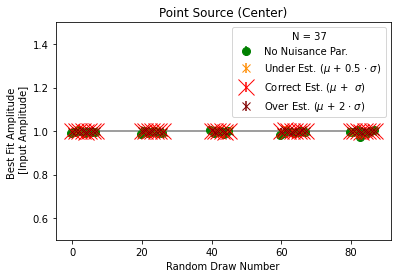

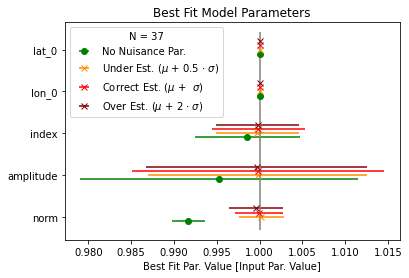

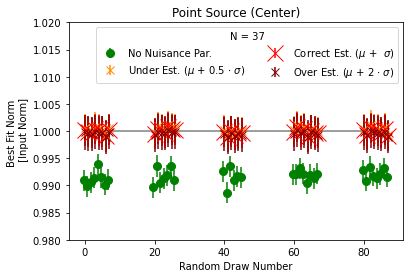

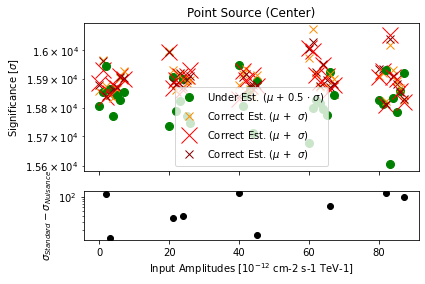

In [7]:
amplitude = 1e-11
rnds= get_finished_rnds(amplitude)

analysis_1e11 = import_parameters_helper.analysis('pointsource_center_624', amplitude, rnds, True)
analysis_1e11.best_fit_amplitudes()
single_plot_amplitudes(analysis_1e11)

single_plot_parameter_overview(analysis_1e11)

analysis_1e11.best_fit_norm()
single_plot_norm(analysis_1e11)

fig, ax1, ax2 = single_plot_significance(analysis_1e11)
ax = plt.gca(); ylim = ax1.get_ylim()
ax2.set_yscale('log')
plt.show()


analysis.norm_err_standard [0.0019290256522730676, 0.0019279671422964635, 0.0019291139716345752, 0.0019297379156676805, 0.0019321536423510149, 0.0019295056738500244, 0.0019283857542182546, 0.0019259730162899272, 0.0019274279398877972, 0.0019270119136708841, 0.0019303414252705897, 0.0019280043953326521, 0.0019318588919117665, 0.0019265553821554385, 0.0019303482075016564, 0.0019265073380279791, 0.0019274141899765294, 0.0019321847564889177, 0.0019284679255616919, 0.0019294216106272907, 0.0019303160571233274, 0.0018581580947995635, 0.0019289294483295408, 0.0019298085084197515, 0.0019293661037953717, 0.0019300781275735813, 0.001928335516571235, 0.0019282790608828241, 0.001929755871178977, 0.0019252811167970224, 0.0019333286066800092, 0.0019313476488060071, 0.0019266665130908405, 0.0019318214677203356, 0.001929429753312354, 0.0019296216510922995, 0.0019299468068830644, 0.0019284937177533213, 0.0019274232129825161, 0.0019298122666929994, 0.001929036123383666, 0.0019312968363584893, 0.00192763

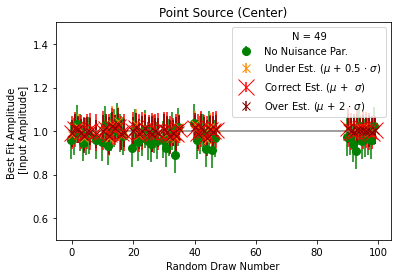

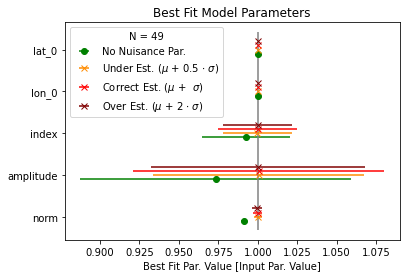

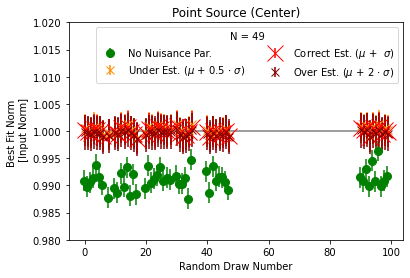

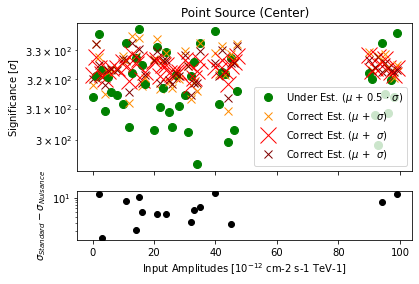

In [8]:
amplitude = 1e-12
rnds= get_finished_rnds(amplitude)

analysis_1e12 = import_parameters_helper.analysis('pointsource_center_624', amplitude, rnds, True)
analysis_1e12.best_fit_amplitudes()
single_plot_amplitudes(analysis_1e12)

single_plot_parameter_overview(analysis_1e12)

analysis_1e12.best_fit_norm()
single_plot_norm(analysis_1e12)

fig, ax1, ax2 = single_plot_significance(analysis_1e12)
ax = plt.gca(); ylim = ax1.get_ylim()
ax2.set_yscale('log')
plt.show()


## Mulitple Amplitudes

In [9]:
def plot_significance(analysiss):
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        for i,aaa  in enumerate(analysiss):
            if i == 0:
                labels_ = [labelstandard] + labels
            else:
                labels_ = ['', ''] * 2
            am = aaa.amplitude * 1e12
            ax1.errorbar(am, aaa.mean_TS_standard, yerr = aaa.std_TS_standard, fmt= fmt_standard, 
                         color= color_overall_standard,
                        label= labels_[0])
            ax1.errorbar(am, aaa.mean_TS_N_under, yerr = aaa.std_TS_N_under, fmt = fmts[0], color= colors_case[0],
                        markersize = 8, label= labels_[1])
            ax1.errorbar(am, aaa.mean_TS_N, yerr = aaa.std_TS_N, fmt = fmts[1], color= colors_case[1],
                        markersize = 16, label= labels_[2])
            ax1.errorbar(am, aaa.mean_TS_N_over, yerr = aaa.std_TS_N_over, fmt = fmts[2], color= colors_case[2],
                        markersize = 8, label= labels_[3])
        
            res = aaa.mean_TS_standard - aaa.mean_TS_N
            ax2.plot(am, res, 'o', color= 'black')
            print(f'ax:{am:.3}= Standard: {aaa.mean_TS_standard:.3} pm {aaa.std_TS_standard:.3}')
            print(f'            N   : {aaa.mean_TS_N:.3} pm {aaa.std_TS_N:.3}')
            
        
        ax1.set_xscale('log'); ax1.set_yscale('log'); 
        xlim = ax1.get_xlim(); 
        #ax1.set_ylim(ylim_sig) ; xlim = ax1.set_xlim(xlim_all[0], xlim_all[1]); 
        ax1.hlines(5, xlim_all[0], xlim_all[1])
        ax1.legend()
        ax1.set_ylabel("Significance [$\sigma$]")
        ax1.set_title("Point Source")

        
        ax2.set_ylabel("$\sigma_{Standard} - \sigma_{Nuisance}$")
        ax2.set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
        ax2.hlines(0, xlim_all[0], xlim_all[1], color = 'grey')
        ax2.grid();  ax1.grid();

        return plt.gcf(), ax1, ax2

ax:1e+02= Standard: 4.35e+05 pm 2.97e+02
            N   : 4.36e+05 pm 8.99e+02
ax:10.0= Standard: 1.58e+04 pm 72.3
            N   : 1.59e+04 pm 50.9
ax:1.0= Standard: 3.18e+02 pm 10.9
            N   : 3.24e+02 pm 2.63


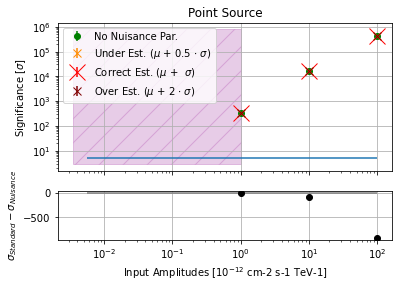

In [10]:
analysiss = [analysis_1e10, analysis_1e11, analysis_1e12 ]
fig, ax1, ax2= plot_significance(analysiss)
ylim = ax1.get_ylim()
ax1.fill_betweenx( y = ylim ,
                 x1 =ax1.get_xlim()[0] , x2=  float(a_threshold['pointsource_center'] )*1e12
                 , color = 'darkmagenta', alpha = 0.2, hatch = '/')

In [31]:

    

def get_set_norm(analysiss):
        mean_norm_x_mins_Ns, mean_norm_x_maxs_Ns = [], []
        std_norm_x_mins_Ns, std_norm_x_maxs_Ns = [], []
        mean_norm_Ns, std_norm_Ns = [], []
        
        mean_norm_x_minss, mean_norm_x_maxss = [], []
        std_norm_x_minss, std_norm_x_maxss = [], []
        mean_norm_standards, std_norm_standards = [], []

        mean_norm_x_mins_N_under_s, mean_norm_x_maxs_N_under_s = [], []
        std_norm_x_mins_N_under_s, std_norm_x_maxs_N_under_s = [], []
        mean_norm_N_under_s, std_norm_N_under_s = [], []
        
        mean_norm_x_mins_N_over_s, mean_norm_x_maxs_N_over_s = [], []
        std_norm_x_mins_N_over_s, std_norm_x_maxs_N_over_s = [], []
        mean_norm_N_over_s, std_norm_N_over_s = [], []
        
        
        ams = []
        for i,aaa  in enumerate(analysiss):
            am = aaa.amplitude * 1e12
            mean_norm_x_mins_Ns.append(aaa.mean_norm_x_mins_N)
            mean_norm_x_maxs_Ns.append(aaa.mean_norm_x_maxs_N)
            std_norm_x_mins_Ns.append(aaa.std_norm_x_mins_N)
            std_norm_x_maxs_Ns.append(aaa.std_norm_x_maxs_N)
            mean_norm_Ns.append(aaa.mean_norm_N)
            std_norm_Ns.append(aaa.std_norm_N)
            
            
            mean_norm_x_mins_N_under_s.append(aaa.mean_norm_x_mins_N_under)
            mean_norm_x_maxs_N_under_s.append(aaa.mean_norm_x_maxs_N_under)
            std_norm_x_mins_N_under_s.append(aaa.std_norm_x_mins_N_under)
            std_norm_x_maxs_N_under_s.append(aaa.std_norm_x_maxs_N_under)
            mean_norm_N_under_s.append(aaa.mean_norm_N_under)
            std_norm_N_under_s.append(aaa.std_norm_N_under)
            
            mean_norm_x_mins_N_over_s.append(aaa.mean_norm_x_mins_N_over)
            mean_norm_x_maxs_N_over_s.append(aaa.mean_norm_x_maxs_N_over)
            std_norm_x_mins_N_over_s.append(aaa.std_norm_x_mins_N_over)
            std_norm_x_maxs_N_over_s.append(aaa.std_norm_x_maxs_N_over)
            mean_norm_N_over_s.append(aaa.mean_norm_N_over)
            std_norm_N_over_s.append(aaa.std_norm_N_over)
            
            
            mean_norm_x_minss.append(aaa.mean_norm_x_mins)
            mean_norm_x_maxss.append(aaa.mean_norm_x_maxs)
            std_norm_x_minss.append(aaa.std_norm_x_mins)
            std_norm_x_maxss.append(aaa.std_norm_x_maxs)
            mean_norm_standards.append(aaa.mean_norm_standard)
            std_norm_standards.append(aaa.std_norm_standard)
            
            ams.append(am)
        
        band_set_N = (mean_norm_x_mins_Ns, mean_norm_x_maxs_Ns,
                std_norm_x_mins_Ns, std_norm_x_maxs_Ns,
                     mean_norm_Ns, std_norm_Ns)
        band_set_N_under = (mean_norm_x_mins_N_under_s, mean_norm_x_maxs_N_under_s,
                std_norm_x_mins_N_under_s, std_norm_x_maxs_N_under_s,
                     mean_norm_N_under_s, std_norm_N_under_s)
        band_set_N_over = (mean_norm_x_mins_N_over_s, mean_norm_x_maxs_N_over_s,
                std_norm_x_mins_N_over_s, std_norm_x_maxs_N_over_s,
                     mean_norm_N_over_s, std_norm_N_over_s)
        band_set_st = (mean_norm_x_minss, mean_norm_x_maxss,
                std_norm_x_minss, std_norm_x_maxss,
                      mean_norm_standards, std_norm_standards)
        
        band_sets = [band_set_st,  band_set_N_under, band_set_N, band_set_N_over ]
        return band_sets, ams
    
    
def get_set_amplitude(analysiss):
        mean_x_mins_Ns, mean_x_maxs_Ns = [], []
        std_x_mins_Ns, std_x_maxs_Ns = [], []
        mean_ampli_Ns, std_ampli_Ns = [], []
        
        mean_x_mins_N_under_s, mean_x_maxs_N_under_s = [], []
        std_x_mins_N_under_s, std_x_maxs_N_under_s = [], []
        mean_ampli_N_under_s, std_ampli_N_under_s = [], []
        
        mean_x_mins_N_over_s, mean_x_maxs_N_over_s = [], []
        std_x_mins_N_over_s, std_x_maxs_N_over_s = [], []
        mean_ampli_N_over_s, std_ampli_N_over_s = [], []
        
        mean_x_minss, mean_x_maxss = [], []
        std_x_minss, std_x_maxss = [], []
        mean_ampli_standards, std_ampli_standards = [], []
        
        ams = []
        for i,aaa  in enumerate(analysiss):
            am = aaa.amplitude * 1e12
            mean_ampli_Ns.append(aaa.mean_ampli_N)
            std_ampli_Ns.append(aaa.std_ampli_N)
            mean_x_mins_Ns.append(aaa.mean_x_mins_N)
            mean_x_maxs_Ns.append(aaa.mean_x_maxs_N)
            std_x_mins_Ns.append(aaa.std_x_mins_N)
            std_x_maxs_Ns.append(aaa.std_x_maxs_N)
            
            mean_ampli_N_under_s.append(aaa.mean_ampli_N_under)
            std_ampli_N_under_s.append(aaa.std_ampli_N_under)
            mean_x_mins_N_under_s.append(aaa.mean_x_mins_N_under)
            mean_x_maxs_N_under_s.append(aaa.mean_x_maxs_N_under)
            std_x_mins_N_under_s.append(aaa.std_x_mins_N_under)
            std_x_maxs_N_under_s.append(aaa.std_x_maxs_N_under)
            
            mean_ampli_N_over_s.append(aaa.mean_ampli_N_over)
            std_ampli_N_over_s.append(aaa.std_ampli_N_over)
            mean_x_mins_N_over_s.append(aaa.mean_x_mins_N_over)
            mean_x_maxs_N_over_s.append(aaa.mean_x_maxs_N_over)
            std_x_mins_N_over_s.append(aaa.std_x_mins_N_over)
            std_x_maxs_N_over_s.append(aaa.std_x_maxs_N_over)
            
            mean_ampli_standards.append(aaa.mean_ampli_standard)
            std_ampli_standards.append(aaa.std_ampli_standard)
            mean_x_minss.append(aaa.mean_x_mins)
            mean_x_maxss.append(aaa.mean_x_maxs)
            std_x_minss.append(aaa.std_x_mins)
            std_x_maxss.append(aaa.std_x_maxs)

            ams.append(am)
        
        band_set_N = (mean_x_mins_Ns, mean_x_maxs_Ns,
                std_x_mins_Ns, std_x_maxs_Ns,
                     mean_ampli_Ns, std_ampli_Ns)
        
        band_set_N_under = (mean_x_mins_N_under_s, mean_x_maxs_N_under_s,
                std_x_mins_N_under_s, std_x_maxs_N_under_s,
                     mean_ampli_N_under_s, std_ampli_N_under_s)
        
        band_set_N_over = (mean_x_mins_N_over_s, mean_x_maxs_N_over_s,
                std_x_mins_N_over_s, std_x_maxs_N_over_s,
                     mean_ampli_N_over_s, std_ampli_N_over_s)
        
        band_set_st = (mean_x_minss, mean_x_maxss,
                std_x_minss, std_x_maxss,
                      mean_ampli_standards, std_ampli_standards)
        band_sets = [band_set_st,band_set_N_under, band_set_N, band_set_N_over]
        return band_sets, ams
    
    
    
    
def plot_band_set(band_sets,ams):
    fig, ax = plt.subplots(1,1, )#figsize =(10,10))
    ax = [ax]
    label =  " (Model+Nui)"
    labelst =  " (Model)"
    bandlabels_ =[labelst, '', label, '']
    labels_ = ["Best Fit "+bandlabels_[0],labelunder, "Best Fit "+bandlabels_[2], labelover]
    band_colors = [ 'yellowgreen', 'black', 'tomato']
    line_colors = [color_overall_standard, 'darkorange', 'red','maroon']
    fmts = ['o', 'o', 'x', 'o']
    markersizes = [6, 4,16,4]

    for i, band_set in enumerate(band_sets):
        print(i, line_colors[i])
        ams_ = np.array(ams) * (1+ 0.2 * i)
        ax[0].errorbar(ams_, band_set[4],
                   yerr = band_set[5], fmt =fmts[i],
                    markersize = markersizes[i],
                       color= line_colors[i],
                  label =  labels_[i])
        if (i%2 ==0):
            ax[0].plot( ams, band_set[0], color = line_colors[i], 
                                   alpha =1, 
                                            label ='Mean Error'+ bandlabels_[i]) 
            ax[0].plot( ams, band_set[1], color = line_colors[i], 
                                   alpha =1, 
                               label ='') 
       
            ax[0].fill_between( ams, band_set[0],  band_set[1] , color = band_colors[i], 
                                   alpha =0.12, 
                                   label ='') 
            errors_min  = np.array(band_set[0]) - np.array(band_set[2])
            errors_max  =  np.array(band_set[0]) + np.array(band_set[2]) 
            ax[0].fill_between( ams, errors_min, errors_max , color =  band_colors[i], 
                                   alpha =0.5, 
                                 label ='Std Error'+  bandlabels_[i]) 
            errors_min  = np.array(band_set[1]) - np.array(band_set[3])
            errors_max  =  np.array(band_set[1]) + np.array(band_set[3]) 
            ax[0].fill_between( ams, errors_min, errors_max , color =  band_colors[i], 
                                   alpha =0.5, 
                                   label ='') 
        #else:
            
            #ax[0].errorbar( ams_,y = band_set[1], yerr=  band_set[2] , color =  line_colors[i], 
            #                       alpha =0.8, fmt = '.'
            #       )#     
            ##ax[0].errorbar( ams_,y = band_set[0], yerr=  band_set[2] , color =  line_colors[i], 
            #                       alpha =0.8, fmt = '.'
            #       )#    label ='Std Error'+  bandlabels_[i]) 

    fmt = 'o:'

    ax[0].set_xscale('log')
    #xlim = ax[0].set_xlim(); 
    ax[0].set_ylim(ylim_norm);# xlim = ax[0].set_xlim(xlim_all[0], xlim_all[1]); 
    ax[0].set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
    ax[0].set_ylabel("Best Fit BG Norm \n [Input BG Norm]")
    xlim = ax[0].get_xlim()
    ax[0].hlines(1,  xlim_all[0], xlim_all[1],color = "grey")
    ax[0].legend(ncol = 2)
    ax[0].set_title("BG Norm Recovery - Point Source")
    return fig , ax[0]

0 green
1 darkorange
2 red
3 maroon


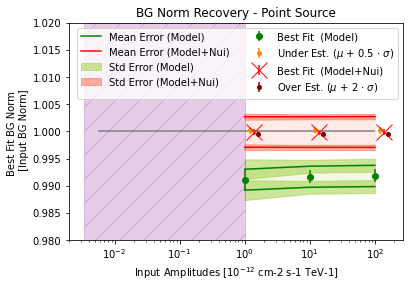

In [32]:
ylim_norm=(0.98,1.02)

band_sets,ams = get_set_norm(analysiss)
fig, ax = plot_band_set(band_sets,ams)
ylim = ax.get_ylim()
ax.fill_betweenx( y = ylim ,
                 x1 =ax.get_xlim()[0] , x2=  float(a_threshold['pointsource_center'] )*1e12
                 , color = 'darkmagenta', alpha = 0.2, hatch = '/')

plt.show()
#fig.savefig("plots/4_Point_source_norm.png")
#fig.savefig("plots/4_Point_source_norm.pdf")

0 green
1 darkorange
2 red
3 maroon


Text(0.5, 1.0, 'Source Amplitude Recovery - Point Source')

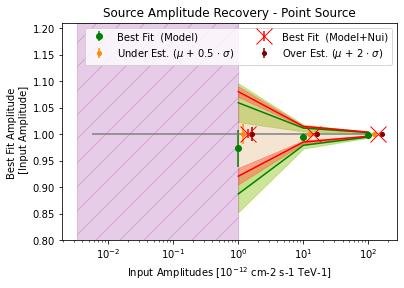

In [30]:
#ylim_norm=(0.98,1.02)
ylim_norm=(0.80,1.21)

band_sets,ams = get_set_amplitude(analysiss)

fig, ax = plot_band_set(band_sets,ams)
ylim = ax.get_ylim()
ax.fill_betweenx( y = ylim ,
                 x1 =ax.get_xlim()[0] , x2=  float(a_threshold['pointsource_center'] )*1e12
                 , color = 'darkmagenta', alpha = 0.2, hatch = '/')

ax.set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
ax.set_ylabel("Best Fit Amplitude \n [Input Amplitude]")
ax.set_title("Source Amplitude Recovery - Point Source")
    
#fig.savefig("plots/4_Point_source_amplitude.png")
#fig.savefig("plots/4_Point_source_amplitude.pdf")
